In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torchvision

### Loading and preparing the data

In [2]:
mnist_train = pd.read_csv('datasets/mnist-in-csv/mnist_train.csv')
mnist_test = pd.read_csv('datasets/mnist-in-csv/mnist_test.csv')

mnist_train.shape, mnist_test.shape

((60000, 785), (10000, 785))

In [3]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
mnist_train = mnist_train.dropna()
mnist_test = mnist_test.dropna()

In [5]:
random_sel = mnist_train.sample(8)
random_sel.shape

(8, 785)

In [6]:
image_features = random_sel.drop('label', axis=1)
image_batch = (torch.Tensor(image_features.values/255.)).reshape((-1,28,28))
image_batch.shape

torch.Size([8, 28, 28])

In [7]:
grid = torchvision.utils.make_grid(image_batch.unsqueeze(1), nrow=8)
grid.shape

torch.Size([3, 32, 242])

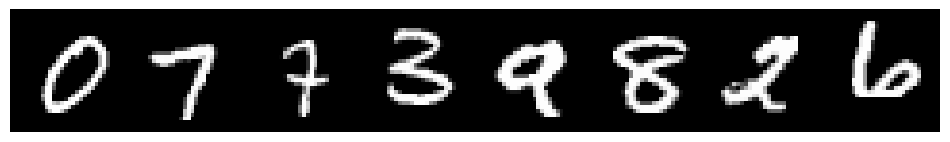

In [8]:
plt.figure(figsize= (12, 12))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

In [9]:
mnist_train_features = mnist_train.drop('label', axis=1)
mnist_train_target = mnist_train['label']

mnist_test_features = mnist_test.drop('label', axis=1)
mnist_test_target = mnist_test['label']

In [10]:
X_train_tensor = torch.tensor(mnist_train_features.values, dtype=torch.float)
X_test_tensor = torch.tensor(mnist_test_features.values, dtype=torch.float)

Y_train_tensor = torch.tensor(mnist_train_target.values, dtype=torch.long)
Y_test_tensor = torch.tensor(mnist_test_target.values, dtype=torch.long)

In [11]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(Y_train_tensor.shape)
print(Y_test_tensor.shape)

torch.Size([60000, 784])
torch.Size([10000, 784])
torch.Size([60000])
torch.Size([10000])


In [12]:
# Reshaping
X_train_tensor = X_train_tensor.reshape(-1, 1, 28, 28)
X_test_tensor = X_test_tensor.reshape(-1, 1, 28, 28)

In [13]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(Y_train_tensor.shape)
print(Y_test_tensor.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000])


### Setting up CNN

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
in_size = 1 # the number of channels in the input image, for the grayscale images = 1

hid1_size = 8
hid2_size = 32

out_size = 10

k_conv_size = 5

In [16]:
class ConvNet(nn.Module):
    
    def __init__(self):
        
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size),
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(512, out_size) # if not sure about the size, print out shapes in forward as shown below
        
        
    def forward(self, x):
        
        out = self.layer1(x)
        #print(out.shape)
        
        out = self.layer2(out)
        #print(out.shape)
        
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        
        out = self.fc(out)
        #print(out.shape) 
        
        return out

### Training CNN

In [17]:
model = ConvNet() # creating instance of the model

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [20]:
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

In [21]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
num_epochs = 10

In [22]:
loss_values = list()

for epoch in range(1, num_epochs):
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()   
    optimizer.step()
    
    print('Epoch - %d, loss - %0.5f ' %(epoch, loss.item()))
    loss_values.append(loss.item())

Epoch - 1, loss - 2.49383 
Epoch - 2, loss - 2.25387 
Epoch - 3, loss - 2.07321 
Epoch - 4, loss - 1.91302 
Epoch - 5, loss - 1.76134 
Epoch - 6, loss - 1.61938 
Epoch - 7, loss - 1.49046 
Epoch - 8, loss - 1.37574 
Epoch - 9, loss - 1.27348 


Text(0, 0.5, 'Loss')

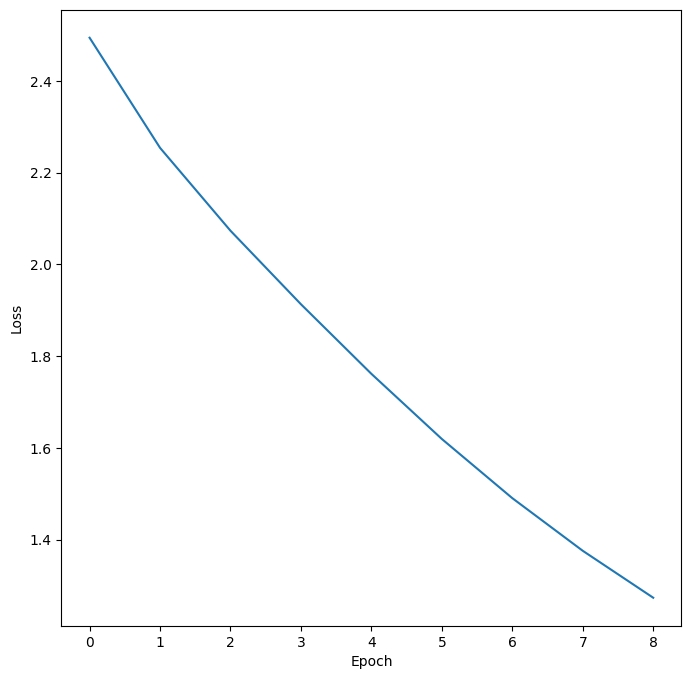

In [23]:
x = (range(0, 9))
plt.figure(figsize= (8, 8))
plt.plot(x, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Model Performance on the Test data

In [24]:
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [26]:
with torch.no_grad():
    
    correct = 0
    total = 0
    
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    Y_test = Y_test_tensor.cpu().numpy()
    predicted = predicted.cpu()
    
    print("Accuracy: ", accuracy_score(predicted, Y_test))
    print("Precision: ", precision_score(predicted, Y_test, average='weighted'))
    print("Recall: ", recall_score(predicted, Y_test, average='weighted'))

Accuracy:  0.772
Precision:  0.7957537506992794
Recall:  0.772
